::: callout-note
**Load Libraries**
- This cell imports core Python packages for data handling, imputation, PCA, scaling, and visualization.
:::

In [37]:
import numpy as np
import os
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import joblib

::: callout-note
**Load and Refine Data**
- We use `KNNImputer` instead of dropping rows to keep as much data as possible.
- The isna() and sum() function is utilized to ensure no columns have NaN values
:::

In [38]:
combine_knn_py_file = "CompleteData.csv"
col_impute = ["Year", "HT", "WT","40","BJ","5 10 5","FLEX", "GPA", "Vert"]

In [39]:
combine_knn_py = pd.read_csv(combine_knn_py_file)

imputer = KNNImputer(n_neighbors=10)
combine_knn_py[col_impute] = imputer.fit_transform(combine_knn_py[col_impute])

print(combine_knn_py[col_impute].isna().sum())

Year      0
HT        0
WT        0
40        0
BJ        0
5 10 5    0
FLEX      0
GPA       0
Vert      0
dtype: int64


::: callout-note
**Dataset Summary**
- Displays key descriptive statistics for each numeric variable.  
- Used to verify data ranges and confirm that imputation was successful before applying scaling and PCA.
:::

In [40]:
combine_knn_py.describe()

,Year,HT,WT,40,BJ,5 10 5,FLEX,GPA,Vert
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,2025.270350,69.287753,199.273554,4.617540,11.488562,4.746517,3.296501,4.327902,28.168936
std,0.555005,11.805654,37.586046,0.935849,17.155088,0.385607,1.099432,5.409156,1.949983
min,2025.000000,0.000000,4.500000,1.630000,0.000000,2.460000,1.000000,2.500000,17.850000
25%,2025.000000,70.000000,175.000000,4.670000,7.865000,4.550000,3.000000,3.750000,27.457500
50%,2025.000000,71.950000,192.000000,4.830000,8.580000,4.720000,3.000000,3.920000,27.965000
75%,2025.200000,73.000000,215.000000,5.042500,8.980000,4.942500,4.000000,4.183000,29.090000
max,2028.000000,77.000000,359.000000,7.370000,122.000000,6.770000,5.000000,93.700000,37.950000


::: callout-note
**Standardize and Apply PCA**
- Uses `StandardScaler()` to normalize each feature to mean = 0 and standard deviation = 1.  
- Applies **Principal Component Analysis (PCA)** to reduce dimensionality while preserving most of the data variance.
:::

In [21]:
scaler = StandardScaler()
scaled_combine_knn_py = scaler.fit_transform(combine_knn_py[col_impute])

pca = PCA(svd_solver = "full")
pca_fit_py = \
pca.fit_transform(scaled_combine_knn_py)

::: callout-note
**Combine PCA Components**
- Converts PCA output into labeled components (`PC1`, `PC2`, …) and appends them to the cleaned dataset.  
- This allows visualization and clustering directly in the reduced PCA feature space.
:::

In [22]:
pca_fit_py = pd.DataFrame(pca_fit_py)
pca_fit_py.columns = \
    ["PC" + str(x + 1) for x in range(len(pca_fit_py.columns))]

combine_knn_py = \
    pd.concat([combine_knn_py, pca_fit_py], axis = 1)

::: callout-note
**Visualize PCA Results**

- Plots `PC1` vs. `PC2` to visualize the structure of the data in reduced dimensions.  
- Helps detect patterns, outliers, and potential natural groupings before clustering.
:::

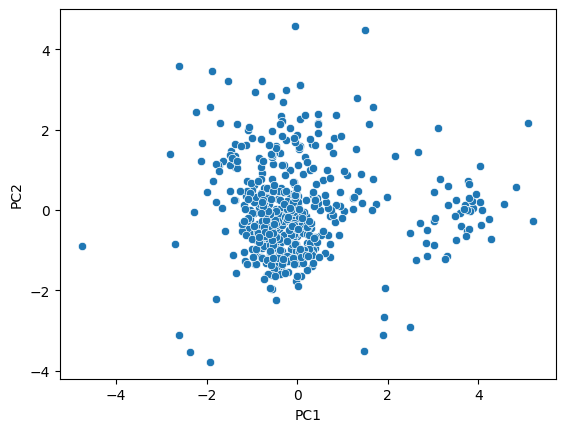

In [23]:
sns.scatterplot(data=combine_knn_py,
                x = "PC1",
                y = "PC2");
plt.show()

::: callout-note
**Color by PC3**

- Adds a third dimension by coloring points according to **PC3 values**.  
- Reveals variation not visible in the 2D projection, helping interpret hidden relationships.
:::

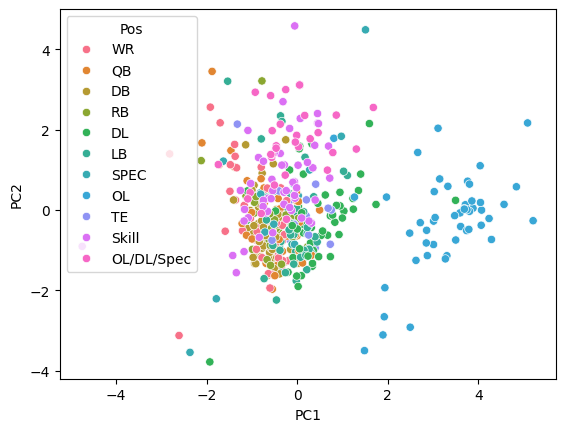

In [25]:
sns.scatterplot(data=combine_knn_py,
                x = "PC1",
                y = "PC2",
                hue="Pos");
plt.show()

::: callout-note
**Color by Position**

- Colors each player’s PCA position by their on-field position (e.g., `WR`, `QB`, `DL`).  
- Demonstrates how athlete roles differ based on physical and performance metrics.
:::

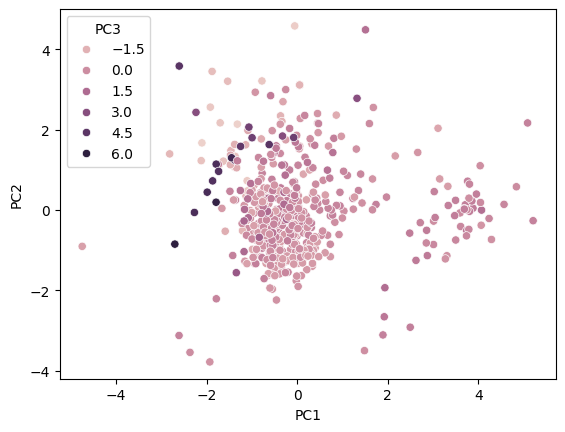

In [24]:
sns.scatterplot(data=combine_knn_py,
                x = "PC1",
                y = "PC2",
                hue="PC3");
plt.show()

::: callout-note
**K-Means Clustering**

- Uses `kmeans()` from `scipy.cluster.vq` to group players into six clusters based on `PC1` and `PC2`.  
- Assigns each player a **cluster label**, identifying groups of similar athletic profiles.
:::

In [26]:
from scipy.cluster.vq import vq, kmeans

k_means_fit_py = \
    kmeans(combine_knn_py[["PC1", "PC2"]], 6, seed = 1234)

::: callout-note
**Inspect Cluster Composition**

- Filters for a specific cluster and groups by position to examine the **distribution** of roles.  
- Calculates the mean and count of height and weight to describe each cluster’s physical profile.
:::

In [27]:
combine_knn_py["cluster"] = \
    vq(combine_knn_py[["PC1", "PC2"]], k_means_fit_py[0])[0]

combine_knn_py.head()

,Last Name,First Name,Pos,Year,HT,WT,40,BJ,5 10 5,FLEX,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,cluster
0,Gaunt,Noah,WR,2025.0,70.0,170.0,4.83,8.78,4.61,3.0,...,-0.552453,-0.100760,0.029240,-0.040877,-0.451315,-0.644661,-0.360993,-0.292047,-0.459073,0
1,Cloninger,Landon,QB,2025.0,70.0,168.0,4.99,9.05,4.65,5.0,...,-0.485666,-0.942726,-0.888733,0.174139,-0.426055,-0.734481,0.460280,0.748461,-0.540194,5
2,Harper,Stiles,DB,2026.0,71.0,162.0,4.80,9.28,4.57,4.0,...,-1.037367,-0.010626,-1.115687,-0.056103,0.588594,-0.082192,0.760329,-0.405096,-0.223217,0
3,White,Jayden,DB,2026.0,72.0,182.0,4.91,9.13,4.80,4.0,...,-0.743077,-0.048514,-0.898093,0.092975,1.072665,0.639700,0.430569,0.192460,0.040215,0
4,LUCAS,JORDAN,WR,2025.0,68.0,178.0,4.75,8.60,4.92,2.0,...,-0.361857,0.550326,0.594156,-0.071676,-0.125390,0.157293,-1.066494,-0.116240,-0.544457,0


::: callout-note
**Summarize Clusters by Position**

- Aggregates height and weight statistics for every position within each cluster.  
- Provides insight into how **body composition** varies across clusters and roles.
:::

In [28]:
print(
    combine_knn_py.query("cluster == 1")
    .groupby("Pos")
    .agg({"HT": ["count", "mean"], "WT": ["count", "mean"]})
)

       HT               WT            
    count       mean count        mean
Pos                                   
DL      1  70.000000     1  270.000000
OL     42  73.455952    42  276.792857


::: callout-note
**Visualize Cluster Distributions**

- Creates a faceted bar chart of position frequencies per cluster.  
- Enables visual comparison of which positions dominate each group.
:::

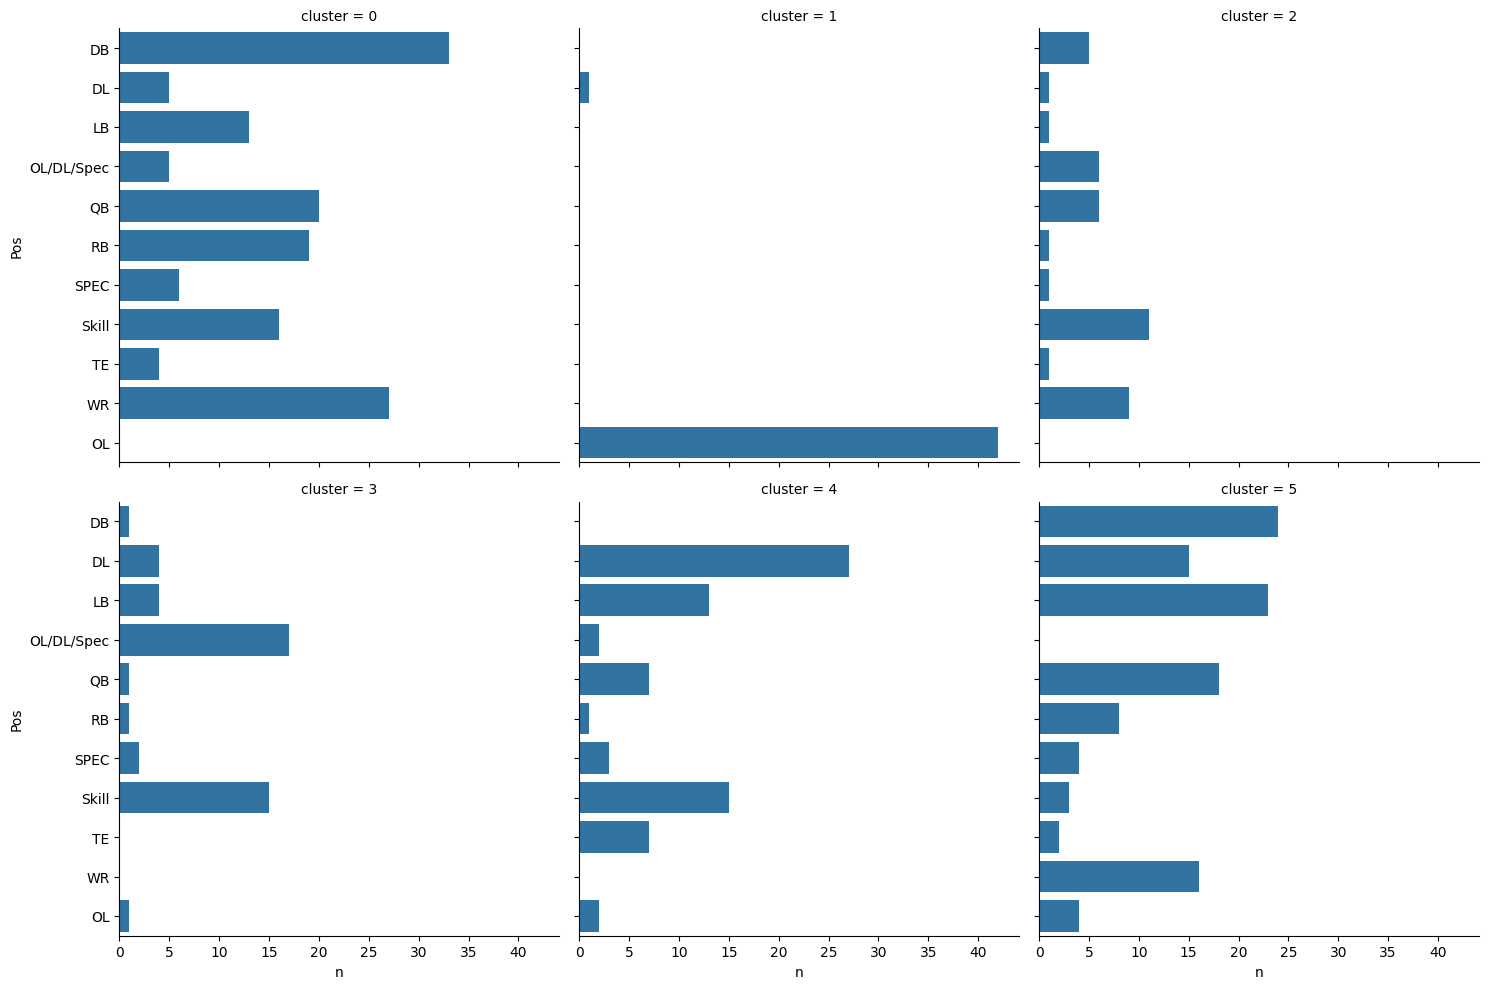

In [29]:
combine_knn_py_cluster = \
    combine_knn_py\
    .groupby(["cluster", "Pos"])\
    .agg({"HT": ["count", "mean"],
          "WT": ["mean"]}
        )
combine_knn_py_cluster.columns = \
    list(map("_".join, combine_knn_py_cluster.columns))

combine_knn_py_cluster.reset_index(inplace=True)

combine_knn_py_cluster\
    .rename(columns={"HT_count": "n",
                     "HT_mean": "HT",
                     "WT_mean": "WT"},
                     inplace=True)

combine_knn_py_cluster.cluster = \
    combine_knn_py_cluster.cluster.astype(str)

sns.catplot(combine_knn_py_cluster, x = "n", y = "Pos", 
            col="cluster", col_wrap = 3, kind = "bar");
plt.show();

::: callout-note
**Cluster Averages**

- Displays overall average **height** and **weight** by cluster.  
- Summarizes the key physical distinctions between clusters.
:::

In [30]:
combine_knn_py_cluster\
    .groupby("cluster")\
    .agg({"HT": ["mean"], "WT": ["mean"]})

,HT,WT
,mean,mean
cluster,,
0,70.979415,185.944977
1,71.727976,273.396429
2,67.923747,165.918354
3,64.412908,200.986471
4,72.161181,211.998573
5,71.545923,199.971237


::: callout-note
**Save Model Pipeline**

- Builds a `Pipeline` for reproducible preprocessing:  
  `KNNImputer` → `StandardScaler` → `PCA` → `KMeans`.  
- Saves the entire model (`pipe`, `feature_cols`, `Z_recruits`, `recruits_meta`, `kmeans`) as `recruit_model.joblib` for later use in the Streamlit app.
:::

In [31]:
FEATURES = ["HT","WT","40","BJ","5 10 5","FLEX","GPA"] 

recruits_df = pd.read_csv("CompleteData.csv")

recruits_meta = recruits_df[["First Name","Last Name","Pos"]].copy()

In [32]:
pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=10)),
    ("scaler",  StandardScaler()),
    ("pca",     PCA(n_components=5, svd_solver="full"))
])

Xr = recruits_df[FEATURES].apply(pd.to_numeric, errors="coerce")
Zr = pipe.fit_transform(Xr)

In [33]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42).fit(Zr)
recruits_meta["cluster"] = kmeans.labels_

In [34]:
joblib.dump(
    {
        "pipe": pipe,
        "feature_cols": FEATURES,
        "Z_recruits": Zr,
        "recruits_meta": recruits_meta.reset_index(drop=True),
        "kmeans": kmeans
    },
    "recruit_model.joblib"
)
print("Saved recruit_model.joblib")

Saved recruit_model.joblib
